conda install sqlite=3.49.* -c conda-forge --force-reinstall

In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import os

# def read_tiff(file_path,prob):
#     """读取TIFF文件并处理缺失值"""
#     dataset = gdal.Open(file_path)
    
#     if dataset is None:
#         raise ValueError("无法打开文件：" + file_path)
    
#     band = dataset.GetRasterBand(1)
#     nodata = band.GetNoDataValue()
#     data = band.ReadAsArray().astype(np.float32)
    
#     # 处理缺失值
#     if nodata is not None:
#         data[data == nodata] = np.nan
    
#     geotrans=dataset.GetGeoTransform()
#     # 处理纬度和数值过滤
#     rows, cols = data.shape
#     x_origin, x_res, x_skew, y_origin, y_skew, y_res = geotrans

#     # 计算每行的纬度（北纬为正）
#     latitudes = y_origin + np.arange(rows) * y_res

#     # 创建纬度掩膜（北纬60度及以上）
#     lat_mask = latitudes >= 60

#     # 应用纬度掩码：只保留60度以北的数据，直接裁剪数组
#     data = data[lat_mask]

#     # 过滤数值范围（保留prob到100之间的值）
#     data[(data < prob) | (data > 100)] = np.nan
#     data = np.flipud(data)

#     return data

import numpy as np
from osgeo import gdal
import xarray as xr

def read_tiff(file_path, prob, downsample_factor=5, method='sample'):
    """
    读取TIFF文件并处理，返回降采样后的DataArray
    Parameters:
        downsample_factor : 降采样比例因子（默认为5）
        method : 降采样方式
            'sample' - 直接采样（默认）
            'mean'  - 局部平均值
    """
    dataset = gdal.Open(file_path)
    
    if dataset is None:
        raise ValueError("无法打开文件：" + file_path)
    
    band = dataset.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    data = band.ReadAsArray().astype(np.float32)
    
    # 处理缺失值
    if nodata is not None:
        data[data == nodata] = np.nan
    
    geotrans = dataset.GetGeoTransform()
    rows, cols = data.shape
    x_origin, x_res, _, y_origin, _, y_res = geotrans  # 忽略旋转参数

    # 计算经纬度网格
    latitudes = y_origin + np.arange(rows) * y_res
    longitudes = x_origin + np.arange(cols) * x_res

    # 创建纬度掩膜（北纬60度及以上）
    lat_mask = latitudes >= 60
    data = data[lat_mask, :]
    filtered_lat = latitudes[lat_mask]

    # 数值范围过滤
    data[(data < prob) | (data > 100)] = np.nan

    # 翻转数据和纬度数组
    data = np.flipud(data)
    filtered_lat = np.flip(filtered_lat)  # 保持纬度与数据行对应

    # 降采样处理
    def downsample(arr, factor, axis):
        if method == 'sample':
            return arr[::factor] if axis == 0 else arr[:, ::factor]
        elif method == 'mean':
            if axis == 0:
                # 处理行方向
                pad_rows = (-arr.shape[0] % factor)
                arr_padded = np.pad(arr, ((0, pad_rows), (0, 0)), 
                                    mode='constant', constant_values=np.nan)
                reshaped = arr_padded.reshape(arr_padded.shape[0] // factor, factor, arr_padded.shape[1])
                return np.nanmean(reshaped, axis=1)
            elif axis == 1:
                # 处理列方向
                pad_cols = (-arr.shape[1] % factor)
                arr_padded = np.pad(arr, ((0, 0), (0, pad_cols)), 
                                    mode='constant', constant_values=np.nan)
                reshaped = arr_padded.reshape(arr_padded.shape[0], arr_padded.shape[1] // factor, factor)
                return np.nanmean(reshaped, axis=2)
    
    # 执行降采样
    print("原始尺寸:", data.shape)
    data = downsample(data, downsample_factor, axis=0)
    print("沿轴0降采样后:", data.shape)
    data = downsample(data, downsample_factor, axis=1)
    print("沿轴1降采样后:", data.shape)
    
    # 调整坐标（注意：当method='mean'时可能需要重新计算坐标，此处保持简单采样）
    filtered_lat = filtered_lat[::downsample_factor] if method == 'sample' else filtered_lat[:data.shape[0]*downsample_factor:downsample_factor]
    longitudes = longitudes[::downsample_factor] if method == 'sample' else longitudes[:data.shape[1]*downsample_factor:downsample_factor]
    
    print("纬度坐标尺寸:", filtered_lat.shape)
    print("经度坐标尺寸:", longitudes.shape)
    
    # 创建DataArray
    return xr.DataArray(
        data,
        dims=('Latitude', 'Longitude'),
        coords={
            'Latitude': filtered_lat,
            'Longitude': longitudes
        },
        attrs={
            'description': f'降采样数据（方法：{method}，比例：1/{downsample_factor}）',
            'original_shape': (rows, cols),
            'downsampled_shape': data.shape
        }
    )
# # 使用示例
# if __name__ == "__main__":
#     # 直接采样模式（默认）
#     da_sample = read_tiff("input.tif", prob=50)
#     print(f"采样模式结果：\n{da_sample}")
    
#     # 平均值降采样模式
#     da_mean = read_tiff("input.tif", prob=50, method='mean')
#     print(f"\n平均值模式结果：\n{da_mean}")
    
#     # 保存结果（NetCDF格式）
#     da_sample.to_netcdf("downsampled_sample.nc")
#     da_mean.to_netcdf("downsampled_mean.nc")


In [2]:
def plot_polar_map(data, title):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    import matplotlib.patches as mpatches
    import numpy as np
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 修正后的导入
    import xarray as xr
    # 创建北极投影画布
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())  # 限定到60N以北

    # 创建圆形边界消除外围区域（关键修改）
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # 改进的地理特征（使用更精细的可缩放数据）
    # --- 高清海岸线配置 ---
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        facecolor='none',  # 无填充
                                        edgecolor='black',  # 深灰
                                        linewidth=2,        # 加粗线宽
                                        linestyle='-')

    land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    facecolor='lightgray',
                                    edgecolor='none')

    # ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
    #                                     facecolor='#E0F0FF')  # 浅蓝色

    # ax.add_feature(ocean, zorder=0)
    ax.add_feature(land, zorder=0)
    ax.add_feature(coast, zorder=1)

    # 数据绘制强化
    mesh = data.sel(Latitude=slice(60, 90)).plot.pcolormesh(
        ax=ax,
        cmap='coolwarm',
        robust=True,
        extend='both',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=2  # 确保数据在图层上方
    )
    # Set colorbar limits
    mesh.set_clim(0, 100)


    # 定制化颜色条
    cbar = plt.colorbar(mesh, orientation='vertical', pad=0.05, shrink=0.7)
    cbar.set_label('Mortality Rate (%)', fontsize=10)  # 更新单位标注
    cbar.ax.tick_params(labelsize=8)


    # 强力经纬网格系统
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,  # 启用标签显示
        linewidth=0.8,
        color='gray',
        alpha=0.6,
        linestyle=':',
        zorder=3
    )
    # 设置经纬度标签的格式和位置
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 5))
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # 设置标签显示的位置
    gl.top_labels = True
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True


        

    plt.title(title, 
            fontsize=14, 
            pad=25, 
            fontweight='bold',
            color='navy')
    plt.show()


In [3]:
def plot_polar_map2(data, title, figname, cbar_min=0, cbar_max=100, overlay_data=None, linewidth=0.5, alpha=0.5):  # 新增overlay_data参数
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    import matplotlib.patches as mpatches
    import numpy as np
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from matplotlib.collections import LineCollection  # 新增导入LineCollection
    import xarray as xr

    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # 创建圆形边界消除外围区域
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # 地理特征（保持不变）
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        facecolor='none',
                                        edgecolor='black',
                                        linewidth=2,
                                        linestyle='-')
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        facecolor='lightgray',
                                        edgecolor='none')
    ax.add_feature(land, zorder=0)
    ax.add_feature(coast, zorder=1)

    # 主数据绘图（保持不变）
    mesh = data.sel(Latitude=slice(60, 90)).plot.pcolormesh(
        ax=ax,
        cmap='Reds',
        robust=True,
        extend='both',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=2
    )
    mesh.set_clim(cbar_min, cbar_max)

    # 新增斜线覆盖层逻辑（改进版）
    if overlay_data is not None:
        # 解包经纬度坐标和数据值
        lons = overlay_data['Longitude'].values
        lats = overlay_data['Latitude'].values
        values = overlay_data.values  # 提取数据矩阵
        
        # 创建坐标网格并扁平化处理
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        flat_lons = lon_grid.ravel()
        flat_lats = lat_grid.ravel()
        flat_values = values.ravel()  # 展平为1D数组
        
        # 生成有效性掩膜
        valid_mask = ~np.isnan(flat_values)  # 布尔型过滤器
        
        # 矢量化的坐标筛选
        valid_lons = flat_lons[valid_mask]
        valid_lats = flat_lats[valid_mask]
        
        # 生成线段集合（EDGE走向调整）
        delta = 0.25  # 增加线长补偿投影形变
        segments = [
            [ (lon-delta, lat+delta), (lon+delta, lat-delta) ] 
            for lon, lat in zip(valid_lons, valid_lats)  # 仅过滤后的点
        ]
        
        # 参数优化后的线型设置
        lc = LineCollection(
            segments,
            colors='black',
            linewidths=linewidth,          # 更细的线条
            linestyles=(0, (2, 3)),  # 断续线（2点实线+1点空白）
            # linestyles='solid',  # 实线
            transform=ccrs.PlateCarree(),
            zorder=4,
            alpha=alpha               # 增加透明度避免过重
        )
        ax.add_collection(lc)

    # 其余部分（颜色条、标签、标题等保持原样）
    cbar = plt.colorbar(mesh, orientation='vertical', pad=0.05, shrink=0.7)
    cbar.set_label('Mortality Rate (%)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.8,
        color='gray',
        alpha=0.6,
        linestyle=':',
        zorder=3
    )
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 5))
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.top_labels = True
    gl.right_labels = False


    plt.title(title, 
            fontsize=14, 
            pad=25, 
            fontweight='bold',
            color='navy')
    
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()

/share/home/yzhang307/miniconda3/envs/pygdal/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


原始尺寸: (600, 7200)
沿轴0降采样后: (120, 7200)
沿轴1降采样后: (120, 1440)
纬度坐标尺寸: (120,)
经度坐标尺寸: (1440,)


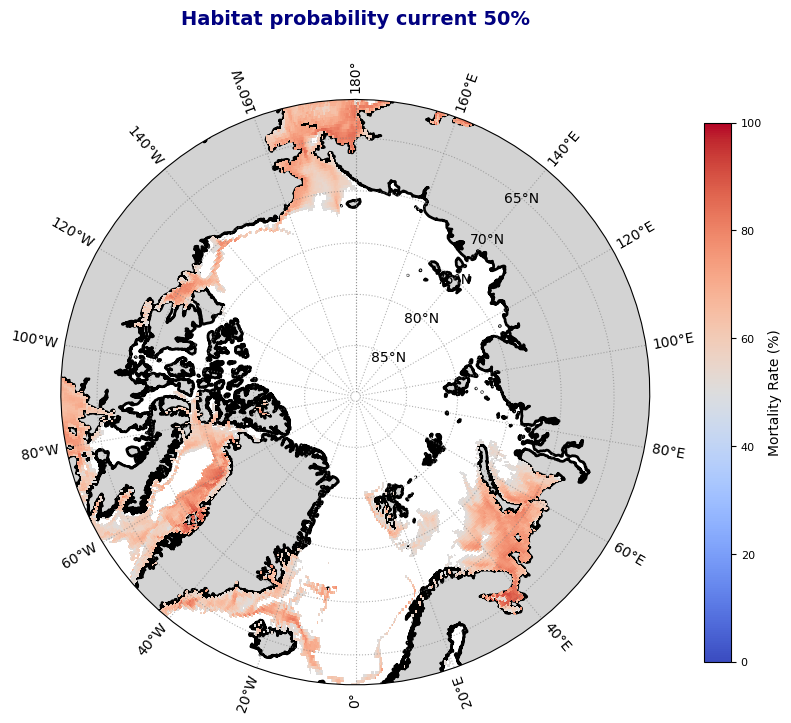

原始尺寸: (600, 7200)
沿轴0降采样后: (120, 7200)
沿轴1降采样后: (120, 1440)
纬度坐标尺寸: (120,)
经度坐标尺寸: (1440,)


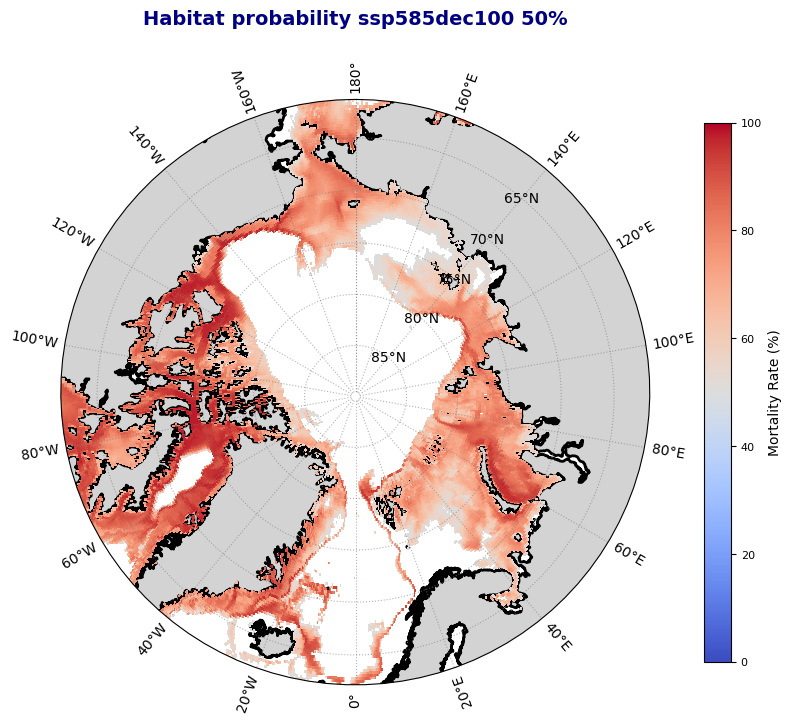

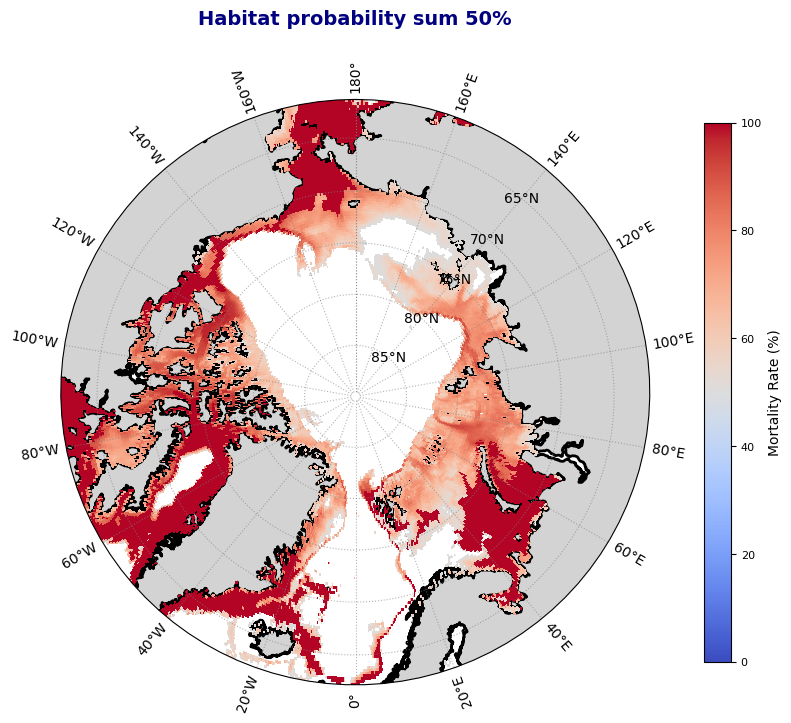

In [4]:
root=os.path.join(os.environ['HOME'], 'eggs', 'model=mpaeu', 'predictions')


# habitatfile=os.path.join(root, 'taxonid=126433_model=mpaeu_method=xgboost_scen=current_cog.tif')
habitatfile=os.path.join(root, 'taxonid=126433_model=mpaeu_method=maxent_scen=current_cog.tif')
prob=50
habitat_xr = read_tiff(habitatfile, downsample_factor=5, method='sample',prob=prob)
plot_polar_map(habitat_xr, f'Habitat probability current {prob}%')


# habitatfile2=os.path.join(root, 'taxonid=126433_model=mpaeu_method=xgboost_scen=ssp585_dec100_what=bootcv_cog.tif')
habitatfile2=os.path.join(root, 'taxonid=126433_model=mpaeu_method=maxent_scen=ssp585_dec100_cog.tif')
habitat_xr2 = read_tiff(habitatfile2, downsample_factor=5, method='sample',prob=prob)
plot_polar_map(habitat_xr2, f'Habitat probability ssp585dec100 {prob}%')


habitat_xr_sum0 =  habitat_xr.fillna(0) + habitat_xr2.fillna(0)
habitat_xr_sum =habitat_xr_sum0.where(habitat_xr_sum0 != 0)
plot_polar_map(habitat_xr_sum, f'Habitat probability sum {prob}%')

habitat_xr.to_netcdf("habitat_maxent_current.nc")
habitat_xr2.to_netcdf("habitat_maxent_ssp585dec100.nc")
habitat_xr_sum.to_netcdf("habitat_maxent_sum.nc")

对habitat_xr和habitat_xr2这两个dataarray均提取北冰洋的不同海区并归类到dataset中。这两个数据的纬度范围是60-90N，经度范围为-180到180，负值为西经正值为东经。 巴伦支海的范围是30E-60E，喀拉海范围是60E-90E，拉普捷夫海范围是100E-140E，东西伯利亚海范围是140E-170E，楚科奇海范围是170E-160W。波佛特海范围是130W-160W，加拿大北极群岛水域范围是80W-130W。巴芬湾范围是60W-80W。大西洋边缘海范围是40W-30E。 请帮我按照这些海区，对两个habitat各自进行提取。提取的方法为：对该海区之外的其他经纬度对应的值，均设置为nan。每一个海区的数据都存成一个dataarray，最后将所有不同海区的数据存到一个dataset里面，并存储到nc文件中。habitat_xr和habitat_xr2分成两个nc文件。

In [5]:
# Define function to extract region data
def extract_region(data, lon_min, lon_max, lat_min, lat_max, region_name):
    """
    Extract a specific region from a DataArray based on longitude and latitude bounds.
    Sets values outside the region to NaN.
    """
    # Create a copy of the data to avoid modifying the original
    region_data = data.copy(deep=True)
    
    # Handle the special case where longitude range crosses the dateline
    if lon_min > lon_max:
        # For example, Chukchi Sea: 170°E to -160°E (crosses the dateline)
        lon_mask = ((region_data.Longitude >= lon_min) | (region_data.Longitude <= lon_max))
    else:
        # Regular case where min is less than max
        lon_mask = ((region_data.Longitude >= lon_min) & (region_data.Longitude <= lon_max))
    
    # Create latitude mask
    lat_mask = ((region_data.Latitude >= lat_min) & (region_data.Latitude <= lat_max))
    
    # Apply both masks - set values outside the region to NaN
    region_data = region_data.where(lon_mask & lat_mask, np.nan)
    
    # Add region name as attribute
    region_data.attrs['region'] = region_name
    
    return region_data

# Define regions with their bounds
regions = {
    'barents_sea': {'lon_min': 20, 'lon_max': 55, 'lat_min': 60, 'lat_max': 75, 'name': 'Barents Sea'},
    'kara_sea': {'lon_min': 55, 'lon_max': 100, 'lat_min': 60, 'lat_max': 75, 'name': 'Kara Sea'},
    'laptev_sea': {'lon_min': 100, 'lon_max': 140, 'lat_min': 60, 'lat_max': 75, 'name': 'Laptev Sea'},
    'east_siberian_sea': {'lon_min': 140, 'lon_max': 170, 'lat_min': 60, 'lat_max': 75, 'name': 'East Siberian Sea'},
    'chukchi_and_bering_sea': {'lon_min': 170, 'lon_max': -160, 'lat_min': 60, 'lat_max': 75, 'name': 'Chukchi and Bering Sea'},
    'beaufort_sea': {'lon_min': -160, 'lon_max': -130, 'lat_min': 60, 'lat_max': 75, 'name': 'Beaufort Sea'},
    'canadian_arctic': {'lon_min': -130, 'lon_max': -80, 'lat_min': 60, 'lat_max': 75, 'name': 'Canadian Arctic Archipelago'},
    'baffin_bay': {'lon_min': -80, 'lon_max': -40, 'lat_min': 60, 'lat_max': 75, 'name': 'Baffin Bay'},
    'atlantic_marginal': {'lon_min': -40, 'lon_max': 20, 'lat_min': 60, 'lat_max': 75, 'name': 'Atlantic Marginal Seas'},
    'center_arctic_and_ice_marginal': {'lon_min': -180, 'lon_max': 180, 'lat_min': 75, 'lat_max': 90, 'name': 'Center Arctic and Sea Ice Marginal'},
    'whole_arctic': {'lon_min': -180, 'lon_max': 180, 'lat_min': 60, 'lat_max': 90, 'name': 'Whole Arctic'},
}

# Create datasets for current and future habitat regions
habitat_current_ds = xr.Dataset()
habitat_future_ds = xr.Dataset()

# Extract regions for the current habitat
for region_id, region_info in regions.items():
    region_data = extract_region(
        habitat_xr, 
        region_info['lon_min'], 
        region_info['lon_max'],
        region_info['lat_min'],  
        region_info['lat_max'],
        region_info['name']
    )
    habitat_current_ds[region_id] = region_data

# Extract regions for the future habitat
for region_id, region_info in regions.items():
    region_data = extract_region(
        habitat_xr2, 
        region_info['lon_min'], 
        region_info['lon_max'],
        region_info['lat_min'],  
        region_info['lat_max'],
        region_info['name']
    )
    habitat_future_ds[region_id] = region_data

# Add global attributes
habitat_current_ds.attrs['description'] = 'Arctic regions of current habitat'
habitat_future_ds.attrs['description'] = 'Arctic regions of future habitat (SSP585 Dec100)'

# Save to NetCDF files
habitat_current_ds.to_netcdf("habitat_maxent_current_regions.nc")
habitat_future_ds.to_netcdf("habitat_maxent_ssp585dec100_regions.nc")

print("Extraction complete. Files saved as:")
print("- habitat_maxent_current_regions.nc")
print("- habitat_maxent_ssp585dec100_regions.nc")

Extraction complete. Files saved as:
- habitat_maxent_current_regions.nc
- habitat_maxent_ssp585dec100_regions.nc


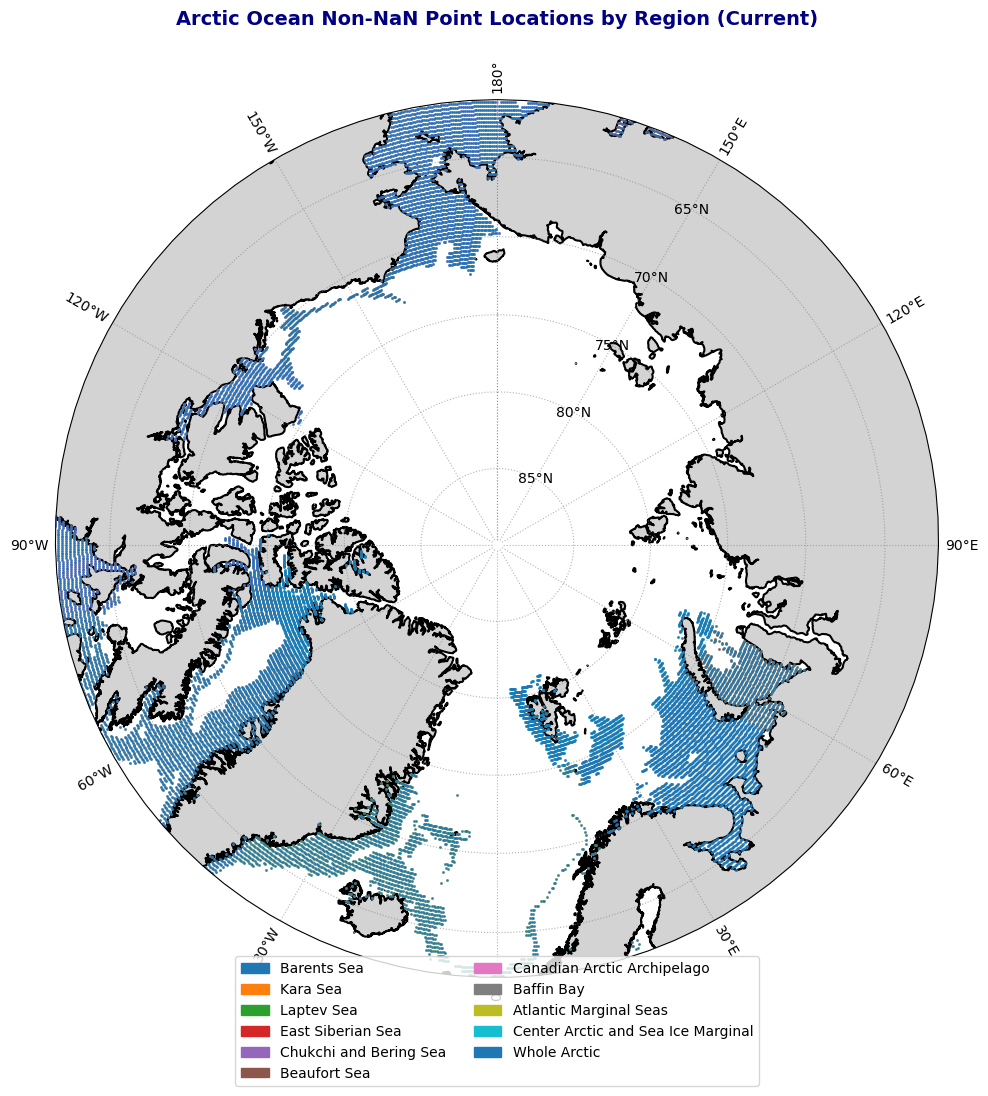

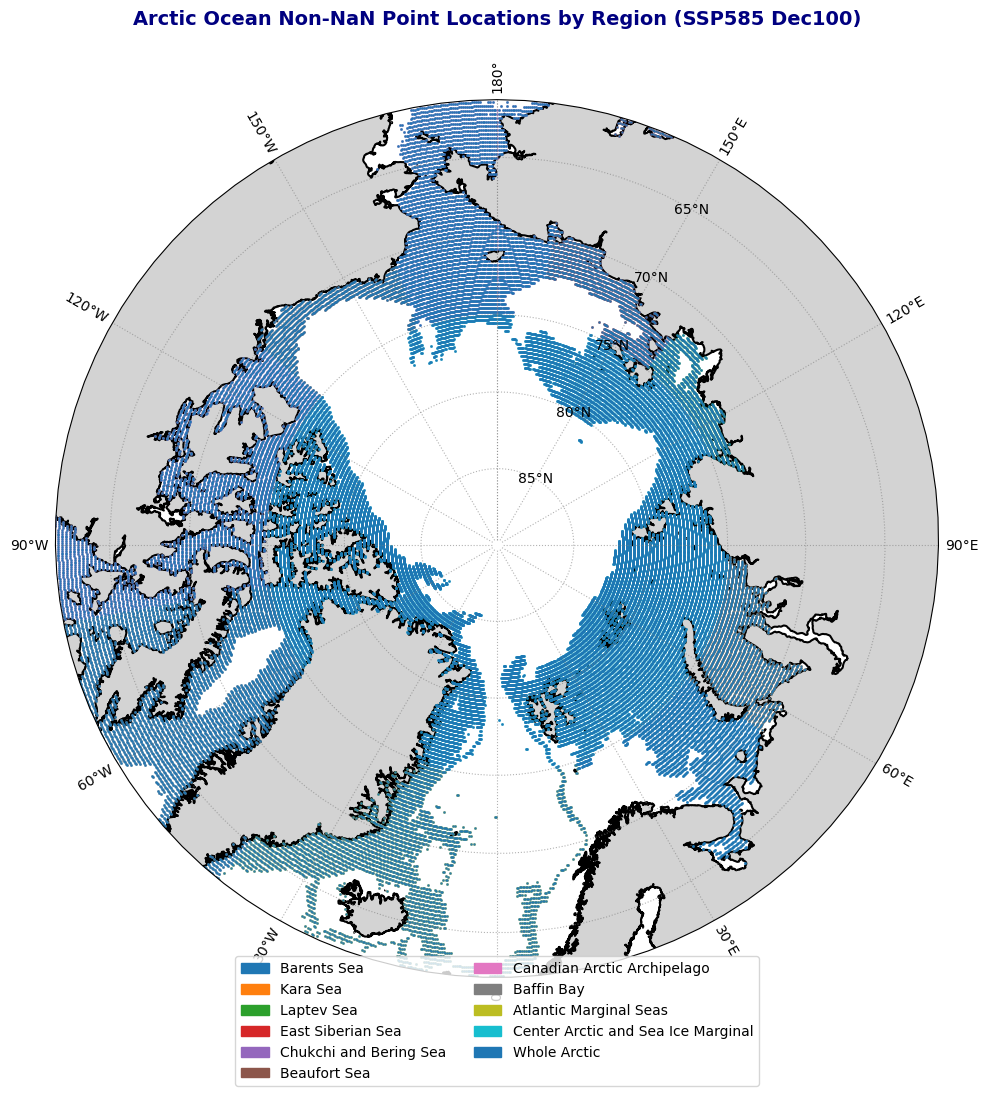

In [6]:
import numpy as np
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def plot_region_habitats(region_ds, title, save_file=None):
    """
    Plot non-NaN point locations for multiple Arctic regions with different colors.
    
    Parameters:
    -----------
    region_ds : xarray.Dataset
        Dataset containing multiple regions as DataArrays
    title : str
        Title for the plot
    save_file : str, optional
        File path to save the figure
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    import matplotlib.patches as mpatches
    
    # Create figure with polar projection
    plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    
    # Create circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add geographic features
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        facecolor='none',
                                        edgecolor='black',
                                        linewidth=1.5)
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        facecolor='lightgray',
                                        edgecolor='none')
    ax.add_feature(land, zorder=0)
    ax.add_feature(coast, zorder=1)
    
    # Define colors for different regions
    colors = plt.cm.tab10.colors
    
    # Plot each region with a different color
    legend_patches = []
    for i, region_name in enumerate(region_ds):
        region_data = region_ds[region_name]
        color = colors[i % len(colors)]
        
        # Get coordinates where data is not NaN
        lons, lats = np.meshgrid(region_data.Longitude, region_data.Latitude)
        valid_points = ~np.isnan(region_data.values)
        
        if np.any(valid_points):
            # Plot points where data exists (not NaN)
            ax.scatter(
                lons[valid_points], 
                lats[valid_points],
                transform=ccrs.PlateCarree(),
                s=1,  # small point size
                color=color,
                alpha=0.7,
                zorder=2,
                label=region_name
            )
        
        # Extract region display name from attributes
        display_name = region_data.attrs.get('region', region_name)
        # Create legend entry
        patch = mpatches.Patch(color=color, label=display_name)
        legend_patches.append(patch)
    
    # Add the legend with the region names
    ax.legend(handles=legend_patches, loc='lower center', 
              bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=10)
    
    # Add gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.8,
        color='gray',
        alpha=0.6,
        linestyle=':',
        zorder=3
    )
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 5))
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.top_labels = True
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    
    # Set title
    plt.title(title, fontsize=14, pad=25, fontweight='bold', color='navy')
    
    # Save figure if save_file is provided
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot current habitat regions
plot_region_habitats(habitat_current_ds, 'Arctic Ocean Non-NaN Point Locations by Region (Current)', 
                    save_file='habitat_current_regions_points.png')

# Plot future habitat regions
plot_region_habitats(habitat_future_ds, 'Arctic Ocean Non-NaN Point Locations by Region (SSP585 Dec100)', 
                    save_file='habitat_future_regions_points.png')


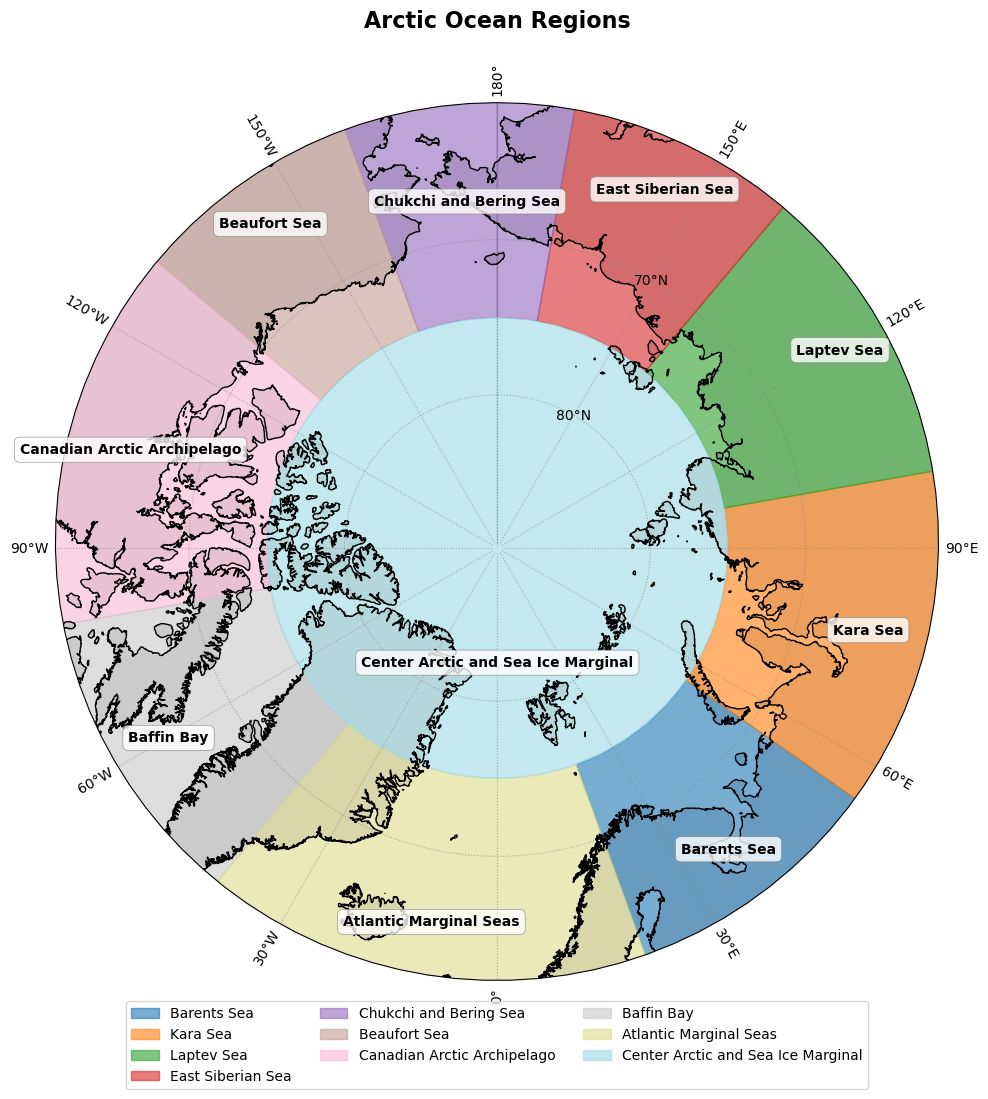

In [7]:
import numpy as np
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
regions = {
    'barents_sea': {'lon_min': 20, 'lon_max': 55, 'lat_min': 60, 'lat_max': 75, 'name': 'Barents Sea'},
    'kara_sea': {'lon_min': 55, 'lon_max': 100, 'lat_min': 60, 'lat_max': 75, 'name': 'Kara Sea'},
    'laptev_sea': {'lon_min': 100, 'lon_max': 140, 'lat_min': 60, 'lat_max': 75, 'name': 'Laptev Sea'},
    'east_siberian_sea': {'lon_min': 140, 'lon_max': 170, 'lat_min': 60, 'lat_max': 75, 'name': 'East Siberian Sea'},
    'chukchi_and_bering_sea': {'lon_min': 170, 'lon_max': -160, 'lat_min': 60, 'lat_max': 75, 'name': 'Chukchi and Bering Sea'},
    'beaufort_sea': {'lon_min': -160, 'lon_max': -130, 'lat_min': 60, 'lat_max': 75, 'name': 'Beaufort Sea'},
    'canadian_arctic': {'lon_min': -130, 'lon_max': -80, 'lat_min': 60, 'lat_max': 75, 'name': 'Canadian Arctic Archipelago'},
    'baffin_bay': {'lon_min': -80, 'lon_max': -40, 'lat_min': 60, 'lat_max': 75, 'name': 'Baffin Bay'},
    'atlantic_marginal': {'lon_min': -40, 'lon_max': 20, 'lat_min': 60, 'lat_max': 75, 'name': 'Atlantic Marginal Seas'},
    'center_arctic_and_ice_marginal': {'lon_min': -180, 'lon_max': 180, 'lat_min': 75, 'lat_max': 90, 'name': 'Center Arctic and Sea Ice Marginal'},
}

# Define correct polygon creation for regions that cross the dateline
def plot_arctic_regions(save_file=None):
    """
    Create a map showing all Arctic Ocean regions based on longitude and latitude boundaries.
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    import matplotlib.patches as mpatches
    
    # Create figure and polar projection
    plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    
    # Create circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.475
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpatches.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add geographic features
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        facecolor='none',
                                        edgecolor='black',
                                        linewidth=1)
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        facecolor='lightgray',
                                        edgecolor='none')
    ax.add_feature(land, zorder=0)
    
    # Define label position adjustments for specific regions
    # Format: [longitude_offset, latitude_offset]
    label_offsets = {
        'barents_sea': [0, -2],
        'kara_sea': [0, -2],
        'laptev_sea': [0, -3],
        'east_siberian_sea': [0, -3],
        'chukchi_sea': [0, -3],
        'beaufort_sea': [0, -3],
        'canadian_arctic': [0, -2],
        'baffin_bay': [0, -2],
        'atlantic_marginal': [0, -2],
        'center_arctic_and_ice_marginal': [0, 0],
    }
    
    # Use colormap for different regions
    colors = plt.cm.tab20(np.linspace(0, 1, len(regions)))
    region_patches = []
    
    # Draw each region as a filled polygon
    for i, (region_id, region_info) in enumerate(regions.items()):
        lon_min = region_info['lon_min']
        lon_max = region_info['lon_max']
        lat_min = region_info['lat_min']
        lat_max = region_info['lat_max']
        name = region_info['name']
        color = colors[i]
        
        # Create polygon vertices for the region
        if lon_min > lon_max:  # Region crosses the dateline
            # Number of points for the arcs
            n_points = 50
            
            # Create the northern boundary as an arc (first segment)
            arc_lons1 = np.linspace(lon_min, 180, n_points)
            arc_lats1 = np.ones(n_points) * lat_max
            
            # Create the southern boundary (first segment)
            south_lons1 = np.linspace(lon_min, 180, n_points)
            south_lats1 = np.ones(n_points) * lat_min
            
            # Combine to form the first polygon (from lon_min to 180)
            lons1 = np.concatenate([south_lons1, [180], arc_lons1[::-1], [lon_min]])
            lats1 = np.concatenate([south_lats1, [lat_min], arc_lats1[::-1], [lat_min]])
            
            # Create the northern boundary as an arc (second segment)
            arc_lons2 = np.linspace(-180, lon_max, n_points)
            arc_lats2 = np.ones(n_points) * lat_max
            
            # Create the southern boundary (second segment)
            south_lons2 = np.linspace(-180, lon_max, n_points)
            south_lats2 = np.ones(n_points) * lat_min
            
            # Combine to form the second polygon (from -180 to lon_max)
            lons2 = np.concatenate([south_lons2, [lon_max], arc_lons2[::-1], [-180]])
            lats2 = np.concatenate([south_lats2, [lat_min], arc_lats2[::-1], [lat_min]])
            
            ax.fill(lons1, lats1, transform=ccrs.PlateCarree(), color=color, alpha=0.6, zorder=2)
            ax.fill(lons2, lats2, transform=ccrs.PlateCarree(), color=color, alpha=0.6, zorder=2)
            
            # Calculate middle longitude correctly for regions crossing dateline
            # For Chukchi Sea, use a specific position to avoid the 0° issue
            if region_id == 'chukchi_and_bering_sea':
                mid_lon = -175  # Place in the middle of the visible region
            else:
                # General formula for regions crossing dateline
                mid_lon = (lon_min + (lon_max + 360)) / 2
                if mid_lon > 180:
                    mid_lon -= 360
                    
        else:
            # Regular region (doesn't cross dateline)
            n_points = 50
            
            # Create the northern boundary as an arc
            arc_lons = np.linspace(lon_min, lon_max, n_points)
            arc_lats = np.ones(n_points) * lat_max
            
            # Create the southern boundary
            south_lons = np.linspace(lon_min, lon_max, n_points)
            south_lats = np.ones(n_points) * lat_min
            
            # Combine to form the polygon
            lons = np.concatenate([south_lons, [lon_max], arc_lons[::-1], [lon_min]])
            lats = np.concatenate([south_lats, [lat_min], arc_lats[::-1], [lat_min]])
            
            ax.fill(lons, lats, transform=ccrs.PlateCarree(), color=color, alpha=0.6, zorder=2)
            mid_lon = (lon_min + lon_max) / 2
        
        # Add to legend
        patch = mpatches.Patch(color=color, label=name, alpha=0.6)
        region_patches.append(patch)
        
        # Calculate adjusted label position with offset
        offset_lon, offset_lat = label_offsets.get(region_id, [0, 0])
        mid_lat = (lat_min + lat_max) / 2 + offset_lat
        label_lon = mid_lon + offset_lon
        
        # Add region label with enhanced visibility
        ax.text(label_lon, mid_lat, name, transform=ccrs.PlateCarree(), fontsize=10,
                ha='center', va='center', fontweight='bold', zorder=5,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', 
                          boxstyle='round,pad=0.4', linewidth=0.5))
    
    ax.add_feature(coast, zorder=3)
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.8, color='gray', alpha=0.6, linestyle=':')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 10))
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    
    # Add legend
    ax.legend(handles=region_patches, loc='lower center', 
              bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
    
    plt.title('Arctic Ocean Regions', fontsize=16, pad=25, fontweight='bold')
    
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to generate the map
plot_arctic_regions(save_file='arctic_regions_map.png')